MMDetection 설치

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection;python setup.py install

KITTI Dataset 다운로드

In [2]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-06-22 02:41:28--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  11.4MB/s    in 0.6s    

2022-06-22 02:41:30 (11.4 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



KITTI DATA FORMAT 확인

In [1]:
# 5번째~8번째가 BOUNDING BOX 정보임. 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 임.
!cat /content/kitti_tiny/training/label_2/000006.txt

Car 0.00 2 -1.55 548.00 171.33 572.40 194.42 1.48 1.56 3.62 -2.72 0.82 48.22 -1.62
Car 0.00 0 -1.21 505.25 168.37 575.44 209.18 1.67 1.64 4.32 -2.61 1.13 31.73 -1.30
Car 0.00 0 0.15 49.70 185.65 227.42 246.96 1.50 1.62 3.88 -12.54 1.64 19.72 -0.42
Car 0.00 1 2.05 328.67 170.65 397.24 204.16 1.68 1.67 4.29 -12.66 1.13 38.44 1.73
DontCare -1 -1 -10 603.36 169.62 631.06 186.56 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 578.97 168.88 603.78 187.56 -1 -1 -1 -1000 -1000 -1000 -10


KITTI annotation 파일들의 리스트들을 가지는 파일 확인.

In [2]:
!cat /content/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


mmdetection의 middle annotation 포맷 변환.
- kitti Dataset을 중립 데이터형태로 변환하여 메모리 로드

In [3]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
import mmcv
import os
import cv2
import numpy as np

@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):

  CLASSES=("Car","Truck","Pedestrian","Cyclist")

  def load_annotations(self,ann_file):
    print("self.data_root :", self.data_root)  # self.data_root  : /content/kitti_tiny
    print("self.ann_file :", self.ann_file)    # self.ann_file   : /content/kitti_tiny/train.txt
    print("self.img_prefix :",self.img_prefix) # self.img_prefix : /content/kitti_tiny/training/image_2

    img_name_list=mmcv.list_from_file(self.ann_file)

    data_infos=[]

    label_dict={k:i for i,k in enumerate(self.CLASSES)}

    for image_id in img_name_list:

      img_file_path=os.path.join(self.img_prefix,str(image_id)+".jpeg")
      # img_file_path : /content/kitti_tiny/training/image_2/000000.jpeg

      img=cv2.imread(img_file_path)
      height, width= img.shape[:2]

      data_info={"filename": str(image_id)+".jpeg", "width":width,"height":height}
     
      label_prefix=self.img_prefix.replace("image_2","label_2")
      # label_prefix : /content/kitti_tiny/training/label_2

      # Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01
      label_list=mmcv.list_from_file(os.path.join(label_prefix,str(image_id)+".txt"))
      
      label_list_content=[i.strip().split(" ") for i in label_list]

      objs_name=[i[0] for i in label_list_content]

      bboxes=[[float(j) for j in i[4:8]]for i in label_list_content]

      gt_bboxes=[]
      gt_labels=[]
      gt_bboxes_ignore=[]
      gt_labels_ignore=[]

      for obj_name,bbox in zip(objs_name,bboxes):
        
        if obj_name in label_dict:
          gt_bboxes.append(bbox)
          gt_labels.append(label_dict[obj_name])
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)

        data_anno={
            "bboxes":np.array(gt_bboxes,dtype=np.float32).reshape(-1,4),
            "labels":np.array(gt_labels,dtype=np.long),
            "bboxes_ignore":np.array(gt_bboxes_ignore,dtype=np.float32).reshape(-1,4),
            "labels_ignore":np.array(gt_labels_ignore,dtype=np.long)
        }

      data_info.update(ann=data_anno)

      data_infos.append(data_info)

    return data_infos
      

In [4]:
!mkdir /content/mmdetection/pretrained_model
!wget -O /content/mmdetection/pretrained_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-06-22 02:49:39--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/pretrained_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  12.1MB/s    in 13s     

2022-06-22 02:49:53 (12.1 MB/s) - ‘/content/mmdetection/pretrained_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [5]:
from mmcv import Config

config_file="/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py"

cfg=Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [7]:
from mmdet.apis import set_random_seed

cfg.model.roi_head.bbox_head.num_classes=4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500,900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500,900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
cfg.dataset_type="KittyTinyDataset"
cfg.data_root="/content/kitti_tiny/"

cfg.data.train.type="KittyTinyDataset"
cfg.data.train.data_root="/content/kitti_tiny/"
cfg.data.train.ann_file = "train.txt"
cfg.data.train.img_prefix="training/image_2"
cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(11500,900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.type="KittyTinyDataset"
cfg.data.val.data_root="/content/kitti_tiny/"
cfg.data.val.ann_file = "val.txt"
cfg.data.val.img_prefix="training/image_2"
cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500,900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]

cfg.data.test.type="KittyTinyDataset"
cfg.data.test.data_root="/content/kitti_tiny/"
cfg.data.test.ann_file = "val.txt"
cfg.data.test.img_prefix="training/image_2"

cfg.evaluation.metric="mAP"
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12

cfg.optimizer.lr=0.02/8
cfg.lr_config.policy="step"
cfg.lr_config.warmup=None

cfg.load_from="/content/mmdetection/pretrained_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth"

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

cfg.log_config.interval=10

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

Config에서 설정한 Dataset과 Model, 동적 학습율, Pipeline 설정에 따라 모델 학습 수행.

In [8]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets=[build_dataset(cfg.data.train)]

self.data_root : /content/kitti_tiny/
self.ann_file : /content/kitti_tiny/train.txt
self.img_prefix : /content/kitti_tiny/training/image_2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [9]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [10]:
datasets[0].CLASSES

('Car', 'Truck', 'Pedestrian', 'Cyclist')

In [11]:
model=build_detector(cfg.model,train_cfg=cfg.get("traing_cfg"),test_cfg=cfg.get("test_cfg"))
model.CLASSES=datasets[0].CLASSES

In [12]:
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

In [13]:
train_detector(model,datasets,cfg,distributed=False, validate=True)

2022-06-22 02:53:18,891 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by i

self.data_root : /content/kitti_tiny/
self.ann_file : /content/kitti_tiny/val.txt
self.img_prefix : /content/kitti_tiny/training/image_2


2022-06-22 02:53:19,223 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-06-22 02:53:19,230 - mmdet - INFO - Start running, host: root@347ab1447b0b, work_dir: /content/tutorial_exps
2022-06-22 02:53:19,233 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpd

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 12.3 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-06-22 02:58:17,550 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 89   | 0.855  | 0.766 |
| Truck      | 3   | 12   | 1.000  | 0.667 |
| Pedestrian | 13  | 39   | 0.923  | 0.837 |
| Cyclist    | 7   | 45   | 0.286  | 0.155 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.606 |
+------------+-----+------+--------+-------+
2022-06-22 02:58:17,553 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.6060, mAP: 0.6061


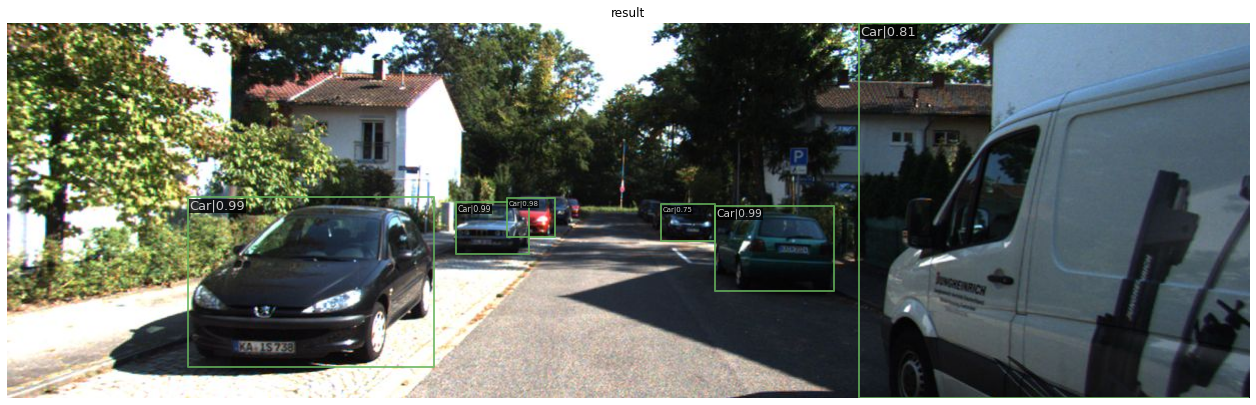

In [16]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000053.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)